# Interactive two population network example

You can experiment with the example code we used in the previous section in this interactive notebook. Use the launcher button above to open this notebook in Binder or Google Colab. Please uncomment the line below if you use the Google Colab. (It does not include these packages by default).

In [1]:
#%pip install pyneuroml neuromllite NEURON

In [2]:
#!/usr/bin/env python3
"""
Create a simple network with two populations.
"""

from neuroml import NeuroMLDocument
from neuroml import Izhikevich2007Cell
from neuroml import Network
from neuroml import ExpOneSynapse
from neuroml import Population
from neuroml import Projection
from neuroml import PulseGenerator
from neuroml import ExplicitInput
from neuroml import Connection
from neuroml import Property
import neuroml.writers as writers
import random
from pyneuroml import pynml
from pyneuroml.lems import LEMSSimulation
import numpy as np

## Declaring the NeuroML model

### Create a NeuroML document

In [3]:
nml_doc = NeuroMLDocument(id="IzNet")

### Declare the Izhikevich cell and add it to the model document

In [4]:
iz0 = Izhikevich2007Cell(
    id="iz2007RS0", v0="-60mV", C="100pF", k="0.7nS_per_mV", vr="-60mV",
    vt="-40mV", vpeak="35mV", a="0.03per_ms", b="-2nS", c="-50.0mV", d="100pA")
nml_doc.izhikevich2007_cells.append(iz0)

### Declare the Synapse and add it to the model document

In [5]:
syn0 = ExpOneSynapse(id="syn0", gbase="65nS", erev="0mV", tau_decay="3ms")
nml_doc.exp_one_synapses.append(syn0)

### Declare a Network and add it to the model document

In [6]:
net = Network(id="IzNet")
nml_doc.networks.append(net)

### Create two populations

In [7]:
size0 = 5
pop0 = Population(id="IzPop0", component=iz0.id, size=size0)
net.populations.append(pop0)

size1 = 5
pop1 = Population(id="IzPop1", component=iz0.id, size=size1)
net.populations.append(pop1)

### Declare projections

In [8]:
proj = Projection(id='proj', presynaptic_population=pop0.id,
                  postsynaptic_population=pop1.id, synapse=syn0.id)
net.projections.append(proj)

### Add the projections between populations and the external inputs

In [9]:
random.seed(123)
prob_connection = 0.8
count = 0
for pre in range(0, size0):
    pg = PulseGenerator(
        id="pg_%i" % pre, delay="0ms", duration="10000ms",
        amplitude="%f nA" % (0.1 + 0.1 * random.random())
    )
    nml_doc.pulse_generators.append(pg)

    exp_input = ExplicitInput(target="%s[%i]" % (pop0.id, pre), input=pg.id)
    net.explicit_inputs.append(exp_input)

    for post in range(0, size1):
        if random.random() <= prob_connection:
            syn = Connection(id=count,
                             pre_cell_id="../%s[%i]" % (pop0.id, pre),
                             synapse=syn0.id,
                             post_cell_id="../%s[%i]" % (pop1.id, post))
            proj.connections.append(syn)
            count += 1

### Write the NeuroML model to a NeuroML file and validate it

In [10]:
nml_file = 'izhikevich2007_network.nml'
writers.NeuroMLWriter.write(nml_doc, nml_file)

print("Written network file to: " + nml_file)
pynml.validate_neuroml2(nml_file)

Written network file to: izhikevich2007_network.nml
pyNeuroML >>> Running jnml on izhikevich2007_network.nml with pre args: [-validate], post args: [], in dir: ., verbose: True, report: True, exit on fail: False
pyNeuroML >>> Executing: (java -Xmx400M  -jar  "/home/padraig/anaconda2/envs/py37/lib/python3.7/site-packages/pyNeuroML-0.5.13-py3.7.egg/pyneuroml/lib/jNeuroML-0.11.0-jar-with-dependencies.jar" -validate "izhikevich2007_network.nml" ) in directory: .
pyNeuroML >>> Command completed. Output: 
pyNeuroML >>>   jNeuroML >>   jNeuroML v0.11.0
pyNeuroML >>>   jNeuroML >>  Validating: /home/padraig/git/Documentation/source/Userdocs/NML2_examples/izhikevich2007_network.nml
pyNeuroML >>>   jNeuroML >>  Valid against schema and all tests
pyNeuroML >>>   jNeuroML >>  No warnings
pyNeuroML >>>   jNeuroML >>  
pyNeuroML >>>   jNeuroML >>  Validated 1 files: All valid and no warnings
pyNeuroML >>>   jNeuroML >>  
pyNeuroML >>>   jNeuroML >>  
pyNeuroML >>> Successfully ran the following comm

True

## Simulating the model
### Create a simulation instance of the model

In [11]:
simulation_id = "example_izhikevich2007network_sim"
simulation = LEMSSimulation(sim_id=simulation_id,
                            duration=1000, dt=0.1, simulation_seed=123)
simulation.assign_simulation_target(net.id)
simulation.include_neuroml2_file(nml_file)

### Define the output file to store spikes

In [12]:
simulation.create_event_output_file(
    "pop0", "%s.0.spikes.dat" % simulation_id, format='ID_TIME'
)
for pre in range(0, size0):
    simulation.add_selection_to_event_output_file(
        "pop0", pre, 'IzPop0[{}]'.format(pre), 'spike')

simulation.create_event_output_file(
    "pop1", "%s.1.spikes.dat" % simulation_id, format='ID_TIME'
)
for pre in range(0, size1):
    simulation.add_selection_to_event_output_file(
        "pop1", pre, 'IzPop1[{}]'.format(pre), 'spike')

/home/padraig/anaconda2/envs/py37/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Save the simulation to a file

In [13]:
lems_simulation_file = simulation.save_to_file()

pyNeuroML >>> Written LEMS Simulation example_izhikevich2007network_sim to file: LEMS_example_izhikevich2007network_sim.xml


## Run the simulation using jNeuroML

In [14]:
pynml.run_lems_with_jneuroml(
    lems_simulation_file, max_memory="2G", nogui=True, plot=False
)

True

## Plot the recorded data

pyNeuroML >>> Generating plot: Spike times
pyNeuroML >>> Saved image to example_izhikevich2007network_sim-spikes.png of plot: Spike times


<AxesSubplot:xlabel='time (s)', ylabel='cell ID'>

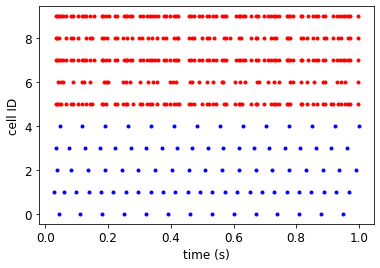

In [15]:
# Load the data from the file and plot the spike times
# using the pynml generate_plot utility function.
data_array_0 = np.loadtxt("%s.0.spikes.dat" % simulation_id)
data_array_1 = np.loadtxt("%s.1.spikes.dat" % simulation_id)
times_0 = data_array_0[:,1]
times_1 = data_array_1[:,1]
ids_0 = data_array_0[:,0]
ids_1 = [id+size0 for id in data_array_1[:,0]]
pynml.generate_plot(
    [times_0,times_1], [ids_0,ids_1],
    "Spike times", show_plot_already=False,
    save_figure_to="%s-spikes.png" % simulation_id,
    xaxis="time (s)", yaxis="cell ID",
    colors=['b','r'],
    linewidths=['0','0'], markers=['.','.'],
)